# Analyze results of simulated transition

In [1]:
"""Further command line arguments:
        c       script will close all open plots
        sli     data of the original simulation written in sli will be analyzed. 
                Note that at this point, the data must be of the same simulation type, 
                as specifications are loaded from .npy-files of the pynest simulation. 

    Overview over all populations: Raster plot, mean rates, mean CV of ISI per population.
"""
from imp import reload
import numpy as np
import h5py
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import rcParams
import sys, os
import time
sys.path.append(os.path.abspath('../presentation')) # include path with style
sys.path.append(os.path.abspath('../transition/')) # include path with simulation specifications
import pres_style as style; reload(style)
# Close other plots by adding 'c' after 'run <script>' 
if 'c' in sys.argv:
    plt.close('all')
picture_format = '.pdf'
figure_path = "./figures"
######################################################
# Import specific moduls
import network_params_trans; reload(network_params_trans)
import user_params_trans as user; reload(user)
%matplotlib inline

show_fig = False
save_fig = True
xfactor = 2.6
style.rcParams['figure.figsize'] = (xfactor*6.2, xfactor*3.83) 
figure_path = os.path.join(".", "figures")

reverse_order = True # do analysis such that plots resemble those of the paper (starting with L6i)
plotting = True

def enum(arr1, *args):
    i_range = range(len(arr1))
    return zip(i_range, arr1 ,*args)

def print_perc(i, i_total):
    i_perc = round(100 * i / i_total)
    print("%i"%(i_perc), end="\r")
    

In [2]:
# DATA
data_path = user.data_dir
sim_spec = "a1.0_t5.2_00"
# Original data
file_name  = sim_spec + ".hdf5"  
res_file_name = sim_spec + "_res.hdf5"


In [3]:
# Open file: data
data_file = h5py.File(os.path.join(data_path, file_name), "r")


area    = data_file.attrs["area"]   
t_sim   = data_file.attrs["t_sim"]  
t_trans = data_file.attrs["t_trans"]
dt      = data_file.attrs["dt"]    
populations   = data_file.attrs["populations"].astype("|U4")
layers        = data_file.attrs["layers"].astype("|U4")        
types         = data_file.attrs["types"].astype("|U4")     
n_populations = data_file.attrs["n_populations"]
n_layers      = data_file.attrs["n_layers"]       
n_types       = data_file.attrs["n_types"] 

t_measure = t_sim - t_trans

# labels & colors: need to be adapted if n_types != (e, i)
layer_colors = style.colors[:n_layers]
colors = np.array([color for color in layer_colors for i in range(n_types)])
colors[1::2] = colors[1::2] * 0.4   #### adapt for more than two types!
if reverse_order:
    populations = populations[::-1]
    layers = layers[::-1]
    types = types[::-1]
    colors = colors[::-1]
data_file.close()

In [4]:
# Analyze spikes
# Open file: data and results
data_file = h5py.File(os.path.join(data_path, file_name), "r")
res_file = h5py.File(os.path.join(data_path, res_file_name), "w")
# Raster plot
t_min_raster = 0.2
t_max_raster = min(t_sim, 1)
max_plot = 0.1 # part of recorded neurons plotten in raster plot

# Spike histogram
bin_width_spikes = 3e-3  # s
n_bins_spikes = int(t_measure / bin_width_spikes) 

for sim_spec2 in data_file.keys():
    print(sim_spec2)
    t0 = time.time()
    
    # Results
    res_grp = res_file.create_group(sim_spec2)
    res_raster = res_grp.create_group("raster") 

    # Data
    grp = data_file[sim_spec2 + "/spikes"]
    dt = grp.attrs["dt"]
    n_neurons_rec_spike = grp.attrs["n_neurons_rec_spike"][:]

    if reverse_order:
        n_neurons_rec_spike = n_neurons_rec_spike[::-1]
    offsets = np.append([0], np.cumsum(n_neurons_rec_spike)) * max_plot
    
    # Mean and Std of firing rates and CV of ISI
    rates_mean  = np.zeros(n_populations)
    rates_std   = np.zeros(n_populations)
    cv_isi_mean = np.zeros(n_populations)
    cv_isi_std  = np.zeros(n_populations)
    synchrony   = np.zeros(n_populations)
    no_isi = []
    
    for i, population in enumerate(populations):
        res_raster_pop = res_raster.create_group(str(population))
        
        # Get data
        subgrp = grp[str(population)]
        raw_times_all   = subgrp["times"][:] * dt * 1e-3 # in seconds
        indices         = subgrp["rec_neuron_i"][:]
        
        # Firing rate:
        n_spikes = np.diff(indices)
        rates = n_spikes / t_measure # Hz

        cv_isi_all = np.empty(0)    
        rates = []
        hist_spikes = np.zeros(n_bins_spikes)
        for j in range(len(indices) - 1):
            times = raw_times_all[indices[j]:indices[j+1]]
            times = times[times > t_trans]
            
            # raster, histogram, etc
            n_spikes = len(times)
            rates.append(n_spikes / t_measure)
            hist_spikes += np.histogram(times, bins=n_bins_spikes, range=(t_trans, t_sim))[0]
            if n_spikes > 1:
                isi = np.diff(times)
                mean_isi = np.mean(isi)
                var_isi = np.var(isi)
                cv_isi = var_isi / mean_isi**2
                cv_isi_all = np.append(cv_isi_all, cv_isi)
            else:
                no_isi.append(str(population) + '_' + str(j))
            
            # data for raster plot
            if j < len(indices) * max_plot:
                raster_mask = (times > t_min_raster) * (times < t_max_raster)
                n_spikes_raster = min(n_spikes, sum(raster_mask))
                neuron_ids_raster = [j]*n_spikes_raster + offsets[i]
                raster_data = np.vstack((times[raster_mask], neuron_ids_raster))
                res_raster_pop.create_dataset(str(j), data=raster_data)

        # Means
        rates_mean[i]   = np.mean(rates)
        rates_std[i]    = np.std(rates)
        cv_isi_mean[i]  = np.mean(cv_isi_all)
        cv_isi_std[i]   = np.std(cv_isi_all)
        synchrony[i]    = np.var(hist_spikes) / np.mean(hist_spikes)
        
    res_raster.attrs["t_min_raster"] = t_min_raster
    res_raster.attrs["t_max_raster"] = t_max_raster
    res_raster.attrs["ymax_raster"] = offsets[-1]
    res_raster.attrs["yticks"] = (offsets[1:] - offsets[:-1]) * 0.5 + offsets[:-1]
        
    res_grp.create_dataset("rates_mean", data=rates_mean)
    res_grp.create_dataset("rates_std", data=rates_std)
    res_grp.create_dataset("cv_isi_mean", data=cv_isi_mean)
    res_grp.create_dataset("cv_isi_std", data=cv_isi_std)
    res_grp.create_dataset("synchrony", data=synchrony)
         
    t_calc = time.time() - t0
    print("Time for calculation: ", t_calc)
          
data_file.close()
res_file.close()

# Free memory from its chains
raw_times_all = None
times = None
raster_mask = None
n_spikes_raster = None
neuron_ids_raster = None
raster_data = None

d0.00_j1.00_sdJ0.00
Time for calculation:  12.477948427200317
d0.10_j1.00_sdJ0.00
Time for calculation:  3.558713674545288
d0.20_j1.00_sdJ0.00
Time for calculation:  3.0232856273651123
d0.30_j1.00_sdJ0.00
Time for calculation:  2.637664794921875
d0.40_j1.00_sdJ0.00
Time for calculation:  2.5355803966522217
d0.50_j1.00_sdJ0.00
Time for calculation:  2.4614346027374268
d0.60_j1.00_sdJ0.00
Time for calculation:  2.452913999557495
d0.70_j1.00_sdJ0.00
Time for calculation:  2.4716851711273193
d0.80_j1.00_sdJ0.00
Time for calculation:  2.459557294845581
d0.90_j1.00_sdJ0.00
Time for calculation:  2.4957706928253174
d1.00_j1.00_sdJ0.00
Time for calculation:  2.437948226928711


/usr/lib/python3/dist-packages/numpy/core/_methods.py:55: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/usr/lib/python3/dist-packages/numpy/core/_methods.py:79: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)


d0.00_j1.00_sdJ0.00
d0.10_j1.00_sdJ0.00
d0.20_j1.00_sdJ0.00
d0.30_j1.00_sdJ0.00
d0.40_j1.00_sdJ0.00
d0.50_j1.00_sdJ0.00
d0.60_j1.00_sdJ0.00
d0.70_j1.00_sdJ0.00
d0.80_j1.00_sdJ0.00
d0.90_j1.00_sdJ0.00
d1.00_j1.00_sdJ0.00


/usr/lib/python3/dist-packages/matplotlib/figure.py:1596: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


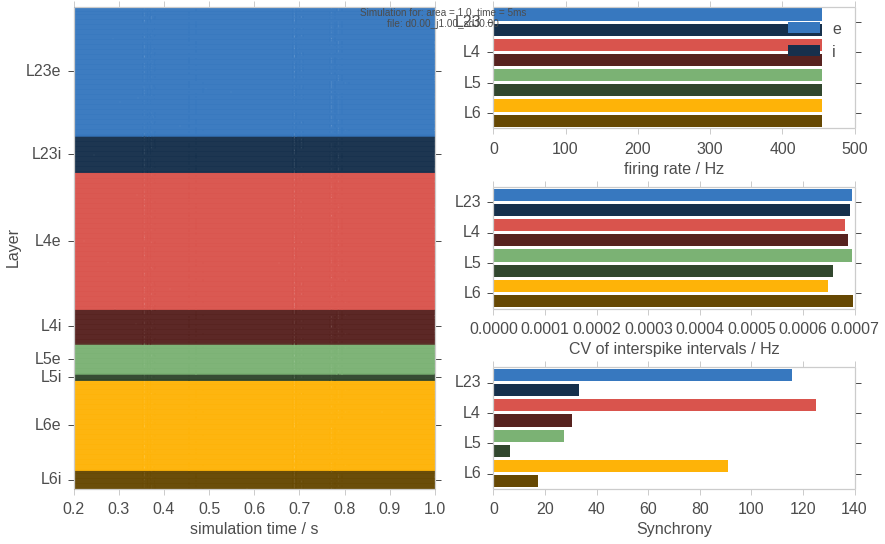

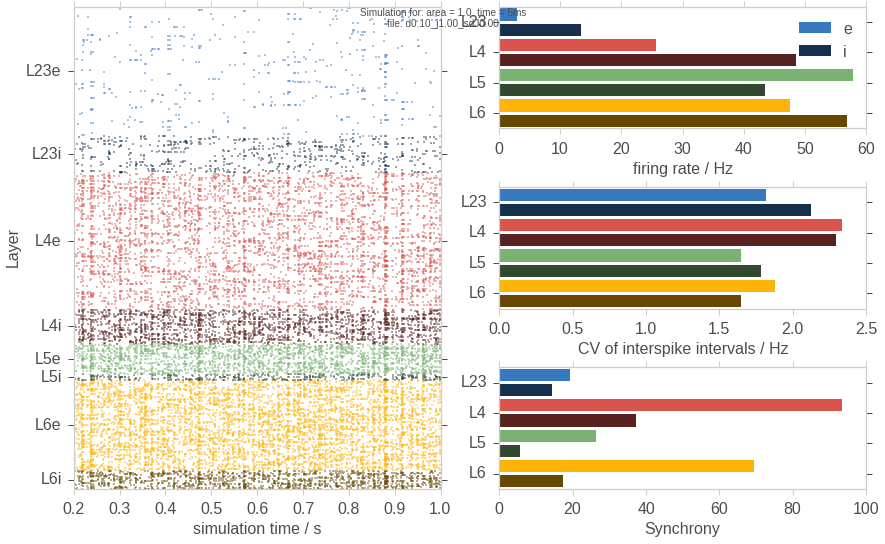

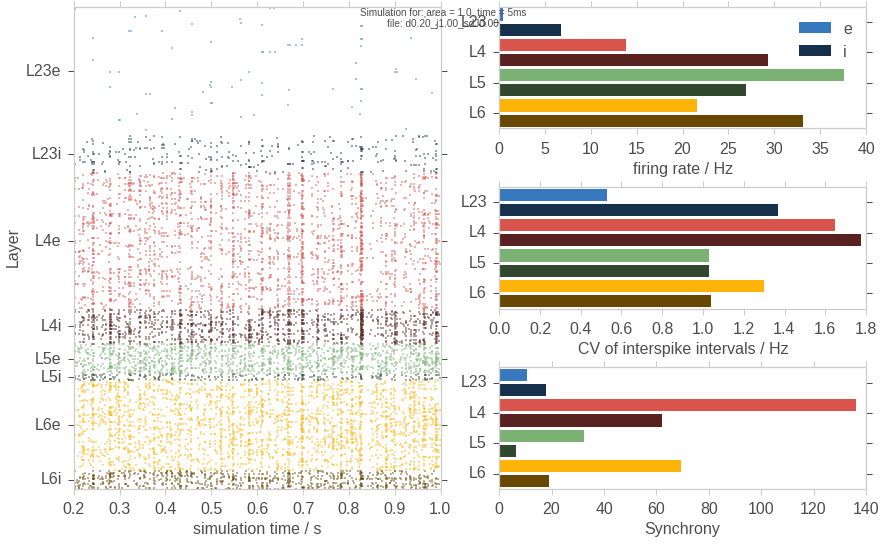

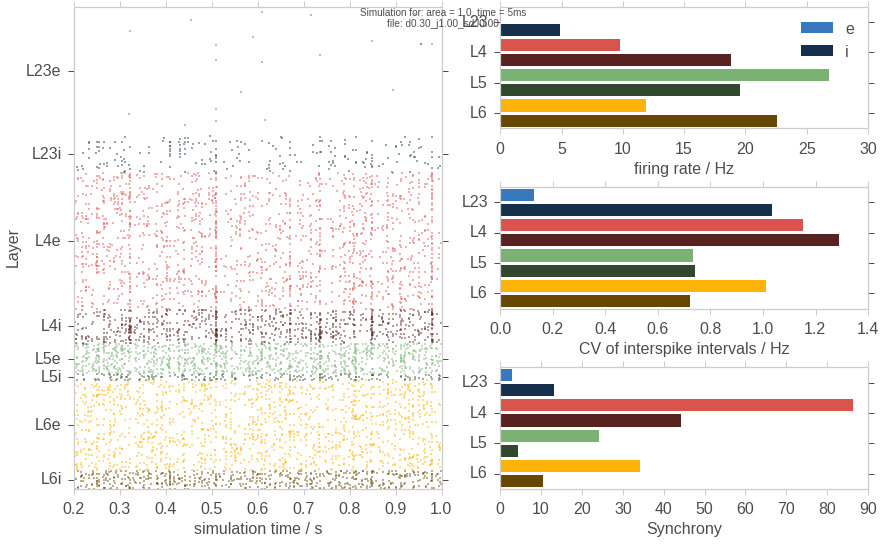

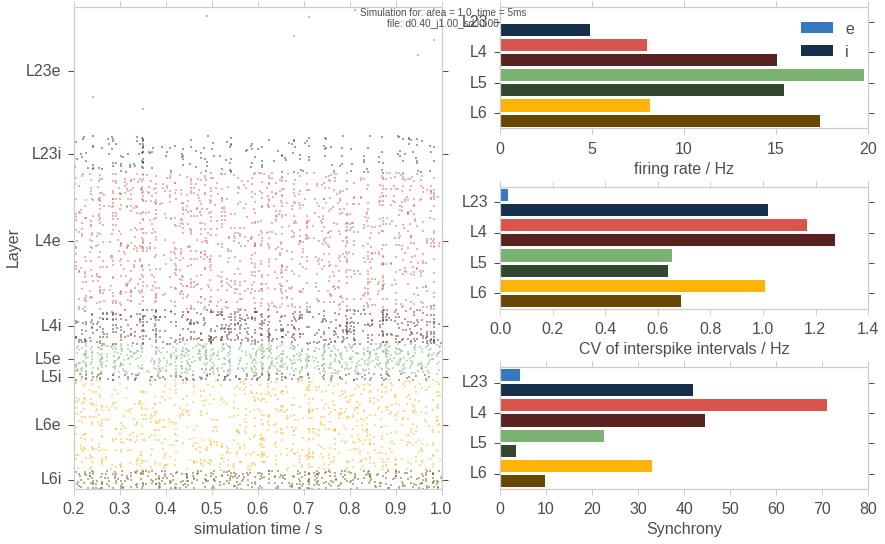

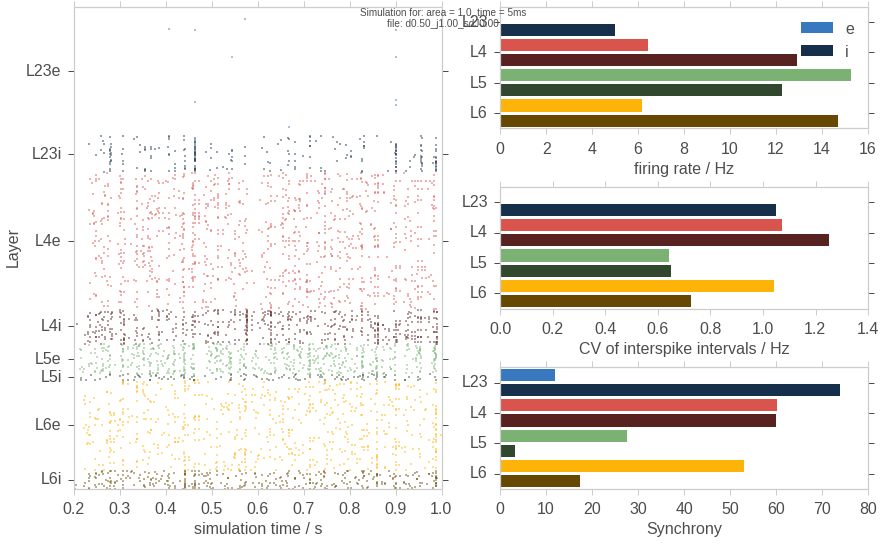

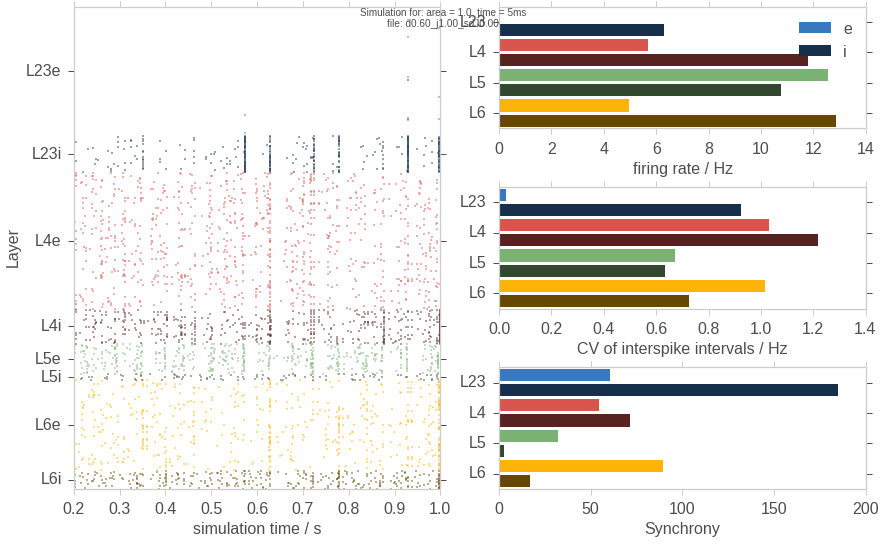

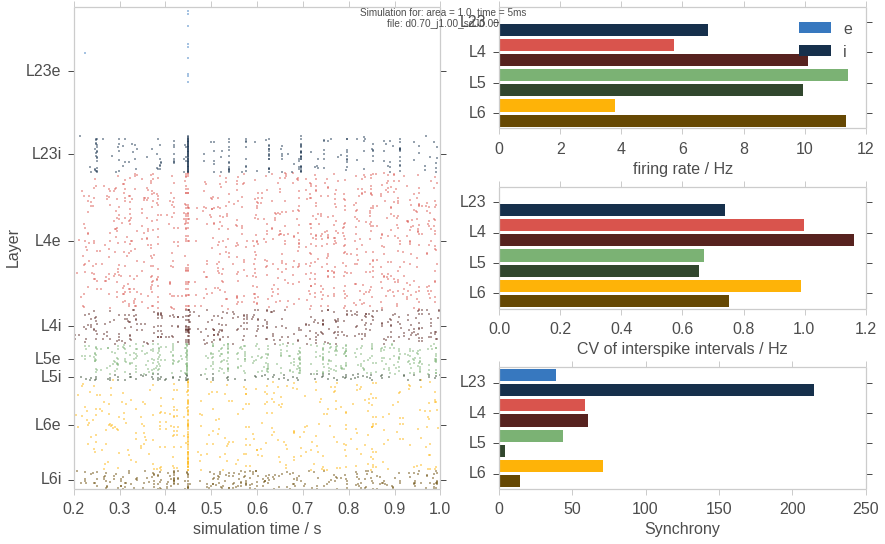

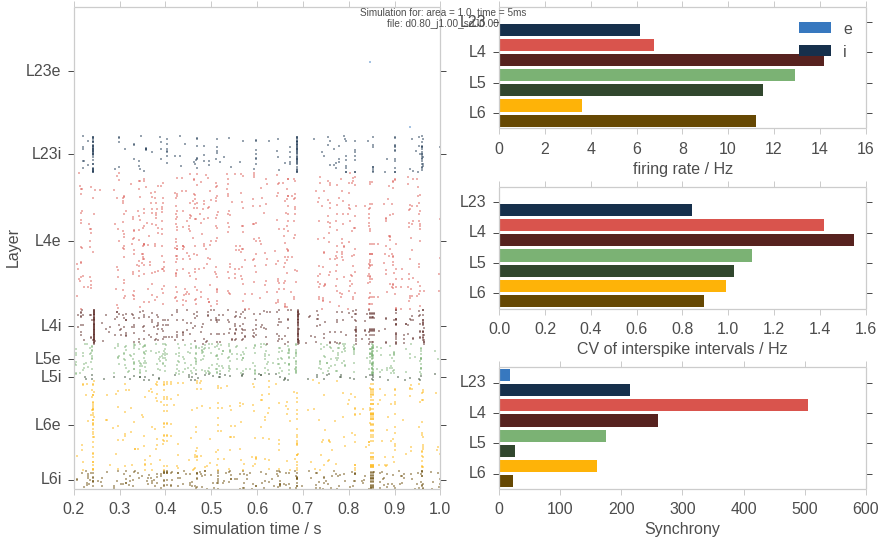

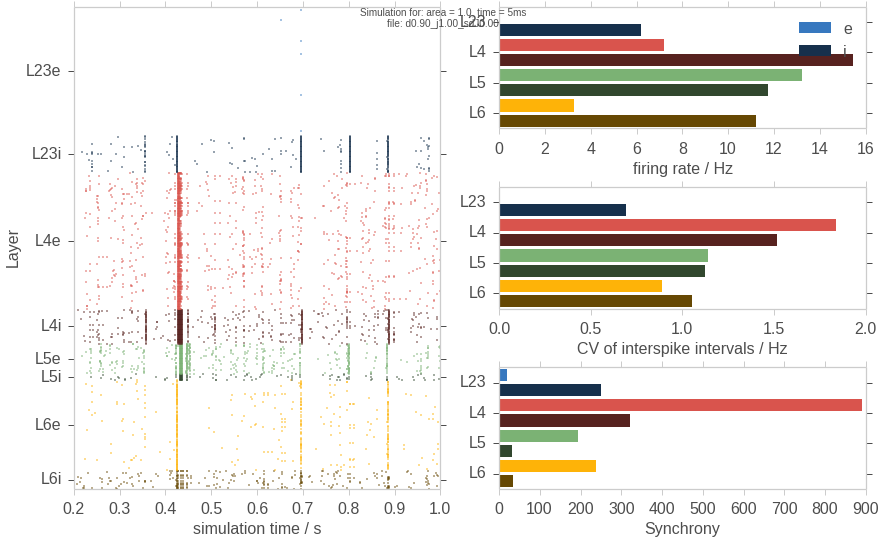

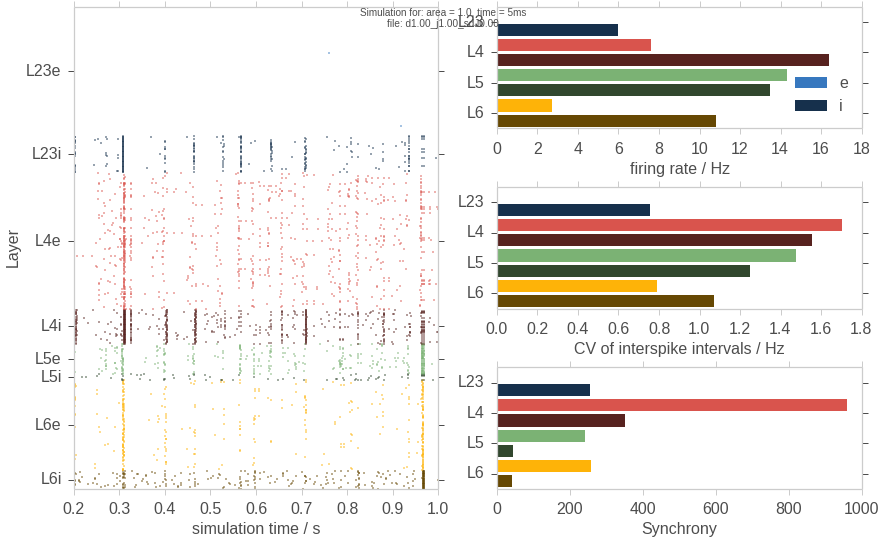

In [5]:
# DATA
data_path = user.data_dir
sim_spec = "a1.0_t5.2_00"
res_file_name = sim_spec + "_res.hdf5"
# Open file: results
res_file = h5py.File(os.path.join(data_path, res_file_name), "r")

# PLOTTING
for sim_spec2 in res_file.keys():  
    print(sim_spec2)
    res_grp = res_file[sim_spec2]
    res_raster = res_grp["raster"]
    
    rates_mean   = res_grp["rates_mean"]
    rates_std    = res_grp["rates_std"]
    cv_isi_mean  = res_grp["cv_isi_mean"]
    cv_isi_std   = res_grp["cv_isi_std"]
    synchrony    = res_grp["synchrony"]
    
    fig = plt.figure()
    suptitle = 'Simulation for: area = %.1f, time = %ims'%(area, t_sim)
    suptitle += '\nfile: ' + sim_spec2
    
    fig.suptitle(suptitle, y=0.98)
    # Raster plot
    ax0 = plt.subplot2grid((3, 2), (0, 0), colspan=1, rowspan=3)
    # Rates
    ax1 = plt.subplot2grid((3, 2), (0, 1), colspan=1, rowspan=1)
    # CV of interspike interval (ISI)
    ax2 = plt.subplot2grid((3, 2), (1, 1), colspan=1, rowspan=1)
    # Synchrony
    ax3 = plt.subplot2grid((3, 2), (2, 1), colspan=1, rowspan=1)    
    
    y_mean = np.arange(n_populations) + 0.1
    bar_height = 0.8 
    for i, population in enumerate(populations):
        res_raster_pop = res_raster[str(population)]
        for times, neuron_ids in res_raster_pop.values():
            ax0.plot(times, neuron_ids, '.', ms=3, color=colors[i], label=population)
        ax1.barh(y_mean[i], rates_mean[i], height=bar_height, color=colors[i], linewidth=0)
        ax2.barh(y_mean[i], cv_isi_mean[i], height=bar_height, color=colors[i], linewidth=0)
        ax3.barh(y_mean[i], synchrony[i],   height=bar_height, color=colors[i], linewidth=0)    
      

    # Raster Plot
    t_min_raster = res_raster.attrs["t_min_raster"]
    t_max_raster = res_raster.attrs["t_max_raster"]
    ymax_raster = res_raster.attrs["ymax_raster"]
    yticks = res_raster.attrs["yticks"]
    
    xlim = (t_min_raster, t_max_raster)
    ylim = (0, ymax_raster)
    ax0.set_yticks(yticks)
    ax0.set_yticklabels(populations)
    ax0.set_xlabel('simulation time / s')
    ax0.set_ylabel('Layer')
    ax0.set_xlim(*xlim)
    ax0.set_ylim(*ylim)
    ax0.grid(False)
      
    # Rates
    ax1.set_xlabel('firing rate / Hz')
    # CV of ISI
    ax2.set_xlabel('CV of interspike intervals / Hz')
    # Synchrony
    ax3.set_xlabel('Synchrony')
    
    ylim_mean = (0, n_populations)
    yticks_mean = np.arange(n_types * 0.5, n_populations, n_types)
    for ax in (ax1, ax2, ax3):
        #ax.set_ylabel('Layer')
        ax.set_yticks(yticks_mean)
        ax.set_yticklabels(layers)
        ax.set_ylim(*ylim_mean)
        ax.grid(False)
    
    # Legend; order is reversed, such that labels appear correctly
    for i in range(n_types):
        ax1.barh(0, 0, 0, color=colors[-(i+1)], label=types[-(i+1)], linewidth=0)
    ax1.legend(loc='best')
    
    for ax in fig.axes:
        style.fixticks(ax)
    fig_name = "cell_activity_" + sim_spec + "_" + sim_spec2
    
    fig.savefig(os.path.join(figure_path,fig_name + picture_format))
    
res_file.close()

# Theoretical predictions

In [2]:
# %load "../transition/trans_mean_field.py"
"""trans_mean_field.py
    Iteratively solve consistency equation for v, starting at 
    model_init, changing towards model_final.
"""
import numpy as np
from scipy.optimize import root
from imp import reload
import network_params_trans; reload(network_params_trans)


def transition(model_init, model_final,  
               v_guess_0=np.array([110, 107, 122, 117, 120, 117, 141, 122]),
               step_init=0.01, d_step=0.5, tolerance=5,
               root_function='siegert',
               jacobian=False, root_method='hybr', options=None):
    """Iteratively solve consistency equation for v, starting at 
    model_init, changing towards model_final.

    Initial guess should not be too far off. Default for Brunel model A in 8D.
    
    Step size is adapted, starting with step_init, 
    adapting size with step *= d_step.
    Maximal number of step decreases = tolerance. 
    
    Further arguments:
    jacobian    ~ whether to use calculated jacobian
    root_method ~ method used by scipy.optimize.root
    options     ~ options for this method

    Returns distances, v0s[distance, population], failures, last model
    """
    # Instantiation
    if jacobian:
        jac = mf_net.jacobian
    else:
        jac = False

    # Run on initial guess v_guess_0
    if root_function=="siegert":
        sol = root(model_init.root_v0_siegert, v_guess_0, jac=jac, method=root_method, options=options)
    else:
        sol = root(model_init.root_v0, v_guess_0, jac=jac, method=root_method, options=options)
    if sol["success"]:
        print("intial success")
        v0  = sol["x"]
        if np.all(v0 < 1./model_init.t_ref): 
            v0s     = v0
            distances = [0]
            v_guess = v0
        else:       # converged unphysically (v0 >= 1/t_ref)
            raise Exception("Converged unphysically for v_guess_0")
    else:   
        raise Exception("No solution found for v_guess_0")
    
    # Define steps and matrices
    step    = step_init     # initial step size
    dist    = 0.
    n_fails = 0
    n_succ  = 0
    failures    = []

    # Looping
    while dist <= 1.:
        dist += step
    
        # New model
        area            = (1. - dist) * model_init.area         + dist * model_final.area        
        n_neurons       = (1. - dist) * model_init.n_neurons    + dist * model_final.n_neurons   
        C_ab            = (1. - dist) * model_init.C_ab         + dist * model_final.C_ab        
        j02             = (1. - dist) * model_init.j02          + dist * model_final.j02         
        g               = (1. - dist) * model_init.g            + dist * model_final.g           
        rate_ext        = (1. - dist) * model_init.rate_ext     + dist * model_final.rate_ext    
        PSC_rel_sd      = (1. - dist) * model_init.PSC_rel_sd   + dist * model_final.PSC_rel_sd  
        delay_rel_sd    = (1. - dist) * model_init.delay_rel_sd + dist * model_final.delay_rel_sd
        model = network_params_trans.net(area=area, 
                                         n_neurons=n_neurons, C_ab=C_ab, 
                                         connection_type="fixed_indegree",
                                         j02=j02, g=g, rate_ext=rate_ext,
                                         PSC_rel_sd=PSC_rel_sd, 
                                         delay_rel_sd=delay_rel_sd) 
        try:
            if root_function=="siegert":
                sol = root(model.root_v0_siegert, v_guess, jac=jac, method=root_method, options=options)
            else:
                sol = root(model.root_v0, v_guess, jac=jac, method=root_method, options=options)
            if sol["success"]:
                v0  = sol["x"]
                if np.all(v0 < 1./model.t_ref): 
                    v0s = np.vstack((v0s, v0))
                    distances.append(dist)
                    v_guess = v0
                    n_fails = 0
                    n_succ  +=1
                    if n_succ >= tolerance and step < step_init:
                        print("succ\t%.5f\t%i %i"%(dist, n_succ, np.log(step)/np.log(d_step)))
                        step /= d_step
                else:       # converged unphysically (v0 >= 1/t_ref)
                    raise Exception("unphysical")
            else:   
                raise Exception("no solution")
        except: # no (good) solution found
            failures.append(dist)
            n_fails += 1
            n_succ   = 0
            print("fail\t%.5f\t%i %i"%(dist, n_fails, np.log(step)/np.log(d_step)))
            dist = distances[-1]
            step    *= d_step
            if n_fails >= tolerance:
                print("Tolerance exceeded at distance = %.3f"%dist)
                break
    distances = np.array(distances)
    failures  = np.array(failures)

    return(distances, v0s, failures, model)     


## Changed only $C_{ab}$

In [8]:
#######################################################
# Global boundaries
#######################################################
# Unchanged parameters
area            = 1.0
connection_type = "fixed_indegree"


g               = 4.0
rate_ext        = 8.0 # Hz background rate
PSC_rel_sd      = 0.0
delay_rel_sd    = 0.0

# Brunel:
j02             = 1.0
n_neurons       = "brunel"
C_ab            = "brunel"
net_brunel      = network_params_trans.net(area=area, 
                                           n_neurons=n_neurons, C_ab=C_ab, 
                                           connection_type=connection_type,
                                           j02=j02, g=g, rate_ext=rate_ext,
                                           PSC_rel_sd=PSC_rel_sd, 
                                           delay_rel_sd=delay_rel_sd) 

# Microcircuit light:
# only some parameters like Potjans" model
# adapt n_neurons AND C_ab!
j02             = 1.0
n_neurons       = "micro"
C_ab            = "micro"
net_micro       = network_params_trans.net(area=area, 
                                           n_neurons=n_neurons, C_ab=C_ab, 
                                           connection_type=connection_type,
                                           j02=j02, g=g, rate_ext=rate_ext,
                                           PSC_rel_sd=PSC_rel_sd, 
                                           delay_rel_sd=delay_rel_sd) 


model_init      = net_brunel
model_final     = net_micro
v_guess_0       = np.array([110, 107, 122, 117, 120, 117, 141, 122])
d_step      = 0.1   # ratio by which step is reduced
step_init   = d_step**3  # initial step size
tolerance   = 5     # number of fails accepted at one distance
root_function = "siegert" # very slow and no difference...
root_function = None
jacobian=False
root_method='hybr'
options=None

t_int0      = time.time()
dists, v0s, fails, last_model = transition(model_init, model_final, 
                                           v_guess_0, step_init, d_step, tolerance,
                                           root_function, jacobian, root_method, options)
t_int1      = time.time() - t_int0
print("Integration time: %.2f"%(t_int1))

intial success
Integration time: 27.71


save figure to numerical_approach_num_only.pdf


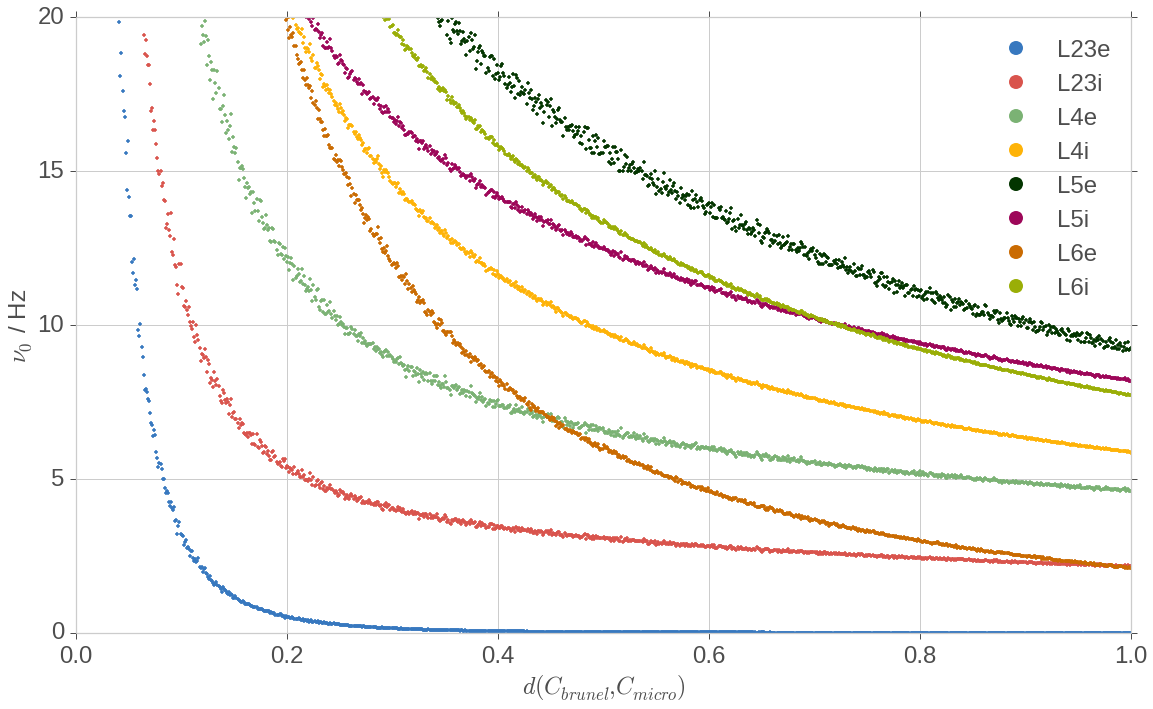

In [9]:
######################################################
# Plotting
######################################################
plot_pops=np.array(['L4e', 'L4i'])
plot_pops= last_model.populations    # These populations are plotted
if not type(plot_pops) == np.ndarray:
    plot_pops = np.array([plot_pops])
i_pop  = np.array([np.where(plot_pop == last_model.populations)[0][0] 
                   for plot_pop in plot_pops])

fig = plt.figure()
if not save_fig:
    suptitle = "Step by step transforming BrunelA to Microcircuit: transform $C_{ab}$" + \
        "\nmethod: " + root_method
    suptitle += "\nfile: " + sim_spec
    fig.suptitle(suptitle, y=0.98)

ax = plt.subplot2grid((1, 1), (0, 0), colspan=1, rowspan=1)
colors = style.colors[:len(plot_pops)]
for i, population in zip(i_pop, plot_pops):
    ax.plot(dists, v0s[:, i], '.', color=colors[i], 
        label=population)
ax.set_xlabel("$d(C_{brunel}, C_{micro})$")
ax.set_ylabel("$\\nu_0$ / Hz")
#ax.set_yscale("log")
ax.grid(True)
ax.legend(loc="best")
ax.set_ylim(0, 20)
ax.set_xlim(0, min(1.0, dists[-1]*1.1))

fig_name = "numerical_approach_num_only"
fig_name += picture_format
    
if save_fig:
    print("save figure to " + fig_name)
    fig.savefig(os.path.join(figure_path,fig_name))
    
if show_fig:
    fig.show()

## Changed $C_{ab}$ and $J_{02}$

In [10]:
#######################################################
# Global boundaries
#######################################################
# Unchanged parameters
area            = 1.0
connection_type = "fixed_indegree"


g               = 4.0
rate_ext        = 8.0 # Hz background rate
PSC_rel_sd      = 0.0
delay_rel_sd    = 0.0

# Brunel:
j02             = 1.0
n_neurons       = "brunel"
C_ab            = "brunel"
net_brunel      = network_params_trans.net(area=area, 
                                           n_neurons=n_neurons, C_ab=C_ab, 
                                           connection_type=connection_type,
                                           j02=j02, g=g, rate_ext=rate_ext,
                                           PSC_rel_sd=PSC_rel_sd, 
                                           delay_rel_sd=delay_rel_sd) 

# Microcircuit light:
# only some parameters like Potjans" model
# adapt n_neurons AND C_ab!
j02             = 2.0
n_neurons       = "micro"
C_ab            = "micro"
net_micro       = network_params_trans.net(area=area, 
                                           n_neurons=n_neurons, C_ab=C_ab, 
                                           connection_type=connection_type,
                                           j02=j02, g=g, rate_ext=rate_ext,
                                           PSC_rel_sd=PSC_rel_sd, 
                                           delay_rel_sd=delay_rel_sd) 


model_init      = net_brunel
model_final     = net_micro
v_guess_0       = np.array([110, 107, 122, 117, 120, 117, 141, 122])
d_step      = 0.1   # ratio by which step is reduced
step_init   = d_step**3  # initial step size
tolerance   = 5     # number of fails accepted at one distance
root_function = "siegert" # very slow and no difference...
root_function = None
jacobian=False
root_method='hybr'
options=None

t_int0      = time.time()
dists, v0s, fails, last_model = transition(model_init, model_final, 
                                           v_guess_0, step_init, d_step, tolerance,
                                           root_function, jacobian, root_method, options)
t_int1      = time.time() - t_int0
print("Integration time: %.2f"%(t_int1))

intial success
Integration time: 23.98


save figure to numerical_approach_num_only.pdf


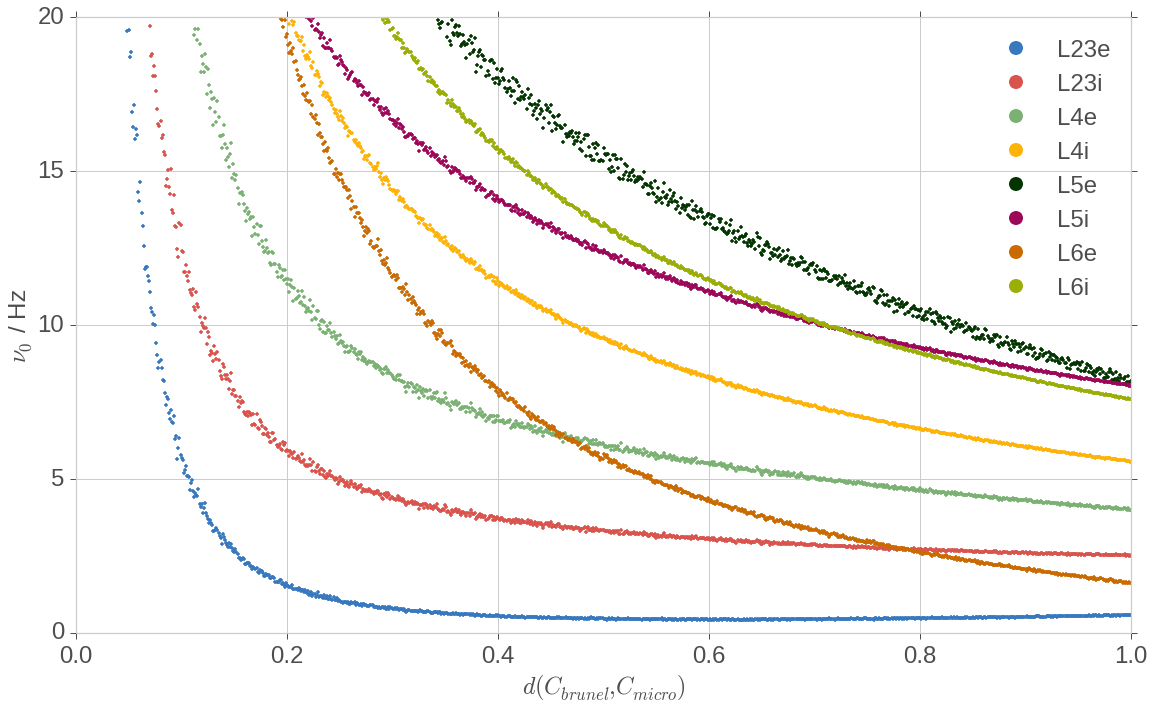

In [11]:
######################################################
# Plotting
######################################################
plot_pops=np.array(['L4e', 'L4i'])
plot_pops= last_model.populations    # These populations are plotted
if not type(plot_pops) == np.ndarray:
    plot_pops = np.array([plot_pops])
i_pop  = np.array([np.where(plot_pop == last_model.populations)[0][0] 
                   for plot_pop in plot_pops])

fig = plt.figure()
if not save_fig:
    suptitle = "Step by step transforming BrunelA to Microcircuit: transform $C_{ab}$" + \
        "\nmethod: " + root_method
    suptitle += "\nfile: " + sim_spec
    fig.suptitle(suptitle, y=0.98)

ax = plt.subplot2grid((1, 1), (0, 0), colspan=1, rowspan=1)
colors = style.colors[:len(plot_pops)]
for i, population in zip(i_pop, plot_pops):
    ax.plot(dists, v0s[:, i], '.', color=colors[i], 
        label=population)
ax.set_xlabel("$d(C_{brunel}, C_{micro})$")
ax.set_ylabel("$\\nu_0$ / Hz")
#ax.set_yscale("log")
ax.grid(True)
ax.legend(loc="best")
ax.set_ylim(0, 20)
ax.set_xlim(0, min(1.0, dists[-1]*1.1))

fig_name = "numerical_approach_num_only"
fig_name += picture_format
    
if save_fig:
    print("save figure to " + fig_name)
    fig.savefig(os.path.join(figure_path,fig_name))
    
if show_fig:
    fig.show()